In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torchsummary import summary
import os

In [ ]:
# os.getcwd()
# os.chdir("/Users/aditya/Documents/self_learning/ERA V3/week 7/micro_cnn")

### Functions & utilities

In [6]:
from src.utils import plot_random_mnist_images

In [7]:
from tqdm import tqdm
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        # Compute loss
        loss = F.nll_loss(output, target)
        train_loss += loss.item() * data.size(0)  # accumulate batch loss
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Update progress bar
        pbar.set_description(desc=f"loss={loss.item():.4f} batch_id={batch_idx}")

    # Compute average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = 100.0 * correct / total

    print(f"\nEpoch {epoch}: Train set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n")
    return avg_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Compute loss
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            
            # Compute accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute average loss and accuracy for the test set
    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy

In [8]:
## Checking if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [9]:
## Checking number of cores available
import multiprocessing
multiprocessing.cpu_count()

8

### Loading MNIST data

In [10]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
batch_size = 512
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

### Creating Base Model
- Aim in this step is to create a based model first which adhere to the constraints of less than 8k parametes
- No major data transformation is used except for normalization
- We will closely monitor the train and test accuracy and loss to understand the model performance
- In assignment 6 we observed one key point around **LR schedueler**. It significantly **improves the training loss convergence**. We will use the same here

In [13]:
from src.model import MiniCNN_1

In [15]:
model = MiniCNN_1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8            [-1, 4, 14, 14]              32
            Conv2d-9            [-1, 8, 14, 14]             288
             ReLU-10            [-1, 8, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,152
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 16, 14, 14]           2,304
             ReLU-14           [-1, 16,

#### Layerwise Details

| Layer | Input Size | Output Size | Receptive Field | Jump In | Jump Out |
|-------|------------|-------------|-----------------|----------|-----------|
| Conv1 | 28x28x1 | 28x28x8 | 3 | 1 | 1 |
| Conv2 | 28x28x8 | 28x28x8 | 5 | 1 | 1 |
| Conv3 | 28x28x8 | 28x28x8 | 7 | 1 | 1 |
| MaxPool1 | 28x28x8 | 14x14x8 | 8 | 1 | 2 |
| Transition-Conv1 | 14x14x8 | 14x14x4 | 8 | 2 | 2 |
| Conv4 | 14x14x4 | 14x14x8 | 12 | 2 | 2 |
| Conv5 | 14x14x8 | 14x14x16 | 16 | 2 | 2 |
| Conv6 | 14x14x16 | 14x14x16 | 20 | 2 | 2 |
| MaxPool2 | 14x14x16 | 7x7x16 | 21 | 2 | 4 |
| Transition-Conv1 | 7x7x16 | 7x7x3 | 21 | 4 | 4 |
| FC | 7x7x3 | 10 | - | - | - |


In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=1e-6,
)

for epoch in range(1, 16):
    print(f"********* Epoch = {epoch} *********")
    train(model, device, train_loader, optimizer, epoch)
    _, acc = test(model, device, test_loader)
    scheduler.step(acc)

/Users/aditya/miniconda3/envs/era_dl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


********* Epoch = 1 *********


loss=0.1123 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]



Epoch 1: Train set: Average loss: 0.4793, Accuracy: 50720/60000 (84.53%)


Test set: Average loss: 0.0884, Accuracy: 9699/10000 (96.99%)

********* Epoch = 2 *********


loss=0.0897 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]



Epoch 2: Train set: Average loss: 0.0841, Accuracy: 58471/60000 (97.45%)


Test set: Average loss: 0.0583, Accuracy: 9810/10000 (98.10%)

********* Epoch = 3 *********


loss=0.0231 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s]



Epoch 3: Train set: Average loss: 0.0652, Accuracy: 58801/60000 (98.00%)


Test set: Average loss: 0.0518, Accuracy: 9839/10000 (98.39%)

********* Epoch = 4 *********


loss=0.1406 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s]



Epoch 4: Train set: Average loss: 0.0543, Accuracy: 59012/60000 (98.35%)


Test set: Average loss: 0.0370, Accuracy: 9871/10000 (98.71%)

********* Epoch = 5 *********


loss=0.0267 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]



Epoch 5: Train set: Average loss: 0.0457, Accuracy: 59178/60000 (98.63%)


Test set: Average loss: 0.0376, Accuracy: 9867/10000 (98.67%)

********* Epoch = 6 *********


loss=0.0315 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  5.00it/s]



Epoch 6: Train set: Average loss: 0.0402, Accuracy: 59227/60000 (98.71%)


Test set: Average loss: 0.0568, Accuracy: 9817/10000 (98.17%)

********* Epoch = 7 *********


loss=0.0690 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]



Epoch 7: Train set: Average loss: 0.0363, Accuracy: 59305/60000 (98.84%)


Test set: Average loss: 0.0427, Accuracy: 9874/10000 (98.74%)

********* Epoch = 8 *********


loss=0.0153 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]



Epoch 8: Train set: Average loss: 0.0367, Accuracy: 59333/60000 (98.89%)


Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

********* Epoch = 9 *********


loss=0.0154 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]



Epoch 9: Train set: Average loss: 0.0337, Accuracy: 59375/60000 (98.96%)


Test set: Average loss: 0.0444, Accuracy: 9858/10000 (98.58%)

********* Epoch = 10 *********


loss=0.0037 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]



Epoch 10: Train set: Average loss: 0.0291, Accuracy: 59439/60000 (99.06%)


Test set: Average loss: 0.0424, Accuracy: 9875/10000 (98.75%)

********* Epoch = 11 *********


loss=0.0116 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]



Epoch 11: Train set: Average loss: 0.0279, Accuracy: 59461/60000 (99.10%)


Test set: Average loss: 0.0413, Accuracy: 9877/10000 (98.77%)

********* Epoch = 12 *********


loss=0.0253 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]



Epoch 12: Train set: Average loss: 0.0291, Accuracy: 59444/60000 (99.07%)


Test set: Average loss: 0.0332, Accuracy: 9906/10000 (99.06%)

********* Epoch = 13 *********


loss=0.0024 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]



Epoch 13: Train set: Average loss: 0.0253, Accuracy: 59521/60000 (99.20%)


Test set: Average loss: 0.0413, Accuracy: 9874/10000 (98.74%)

********* Epoch = 14 *********


loss=0.0757 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s]



Epoch 14: Train set: Average loss: 0.0274, Accuracy: 59452/60000 (99.09%)


Test set: Average loss: 0.0491, Accuracy: 9856/10000 (98.56%)

********* Epoch = 15 *********


loss=0.0372 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]



Epoch 15: Train set: Average loss: 0.0281, Accuracy: 59467/60000 (99.11%)


Test set: Average loss: 0.0402, Accuracy: 9884/10000 (98.84%)



In [17]:
scheduler.get_last_lr()

[0.001]

#### Observations
- Max Train accuracy: 99.20% (Epoch 13)
- Max Test accuracy: 99.06% (Epoch 12)
- Model has reached max accuracy of 99.20% on training data but it is still long way behind 99.4% mark
- There is a significant gap between train and test accuracy
- Test accuracy is varying a lot epoch over epoch


### Creating Bigger Model
- We have not done any data augmentation in the previous model and still the training performance is way behind the desired 99.4% mark
- We will now try to increase the model complexity by adding more parameters while still adhering to the parameter constraint.
- Aim is to see what is maximum level of training accuracy we can achieve and what is the gap between train and test accuracy.
- We will also start with a lower learning rate in aim to overcome the fluctuations in the test accuracy over epochs

In [18]:
from src.model import MiniCNN_2

In [19]:
model = MiniCNN_2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             128
            Conv2d-9            [-1, 8, 14, 14]             576
             ReLU-10            [-1, 8, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,152
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 16, 14, 14]           2,304
             ReLU-14           [-1, 16,

#### Layerwise Details

| Layer | Input Size | Output Size | Receptive Field | Jump In | Jump Out |
|-------|------------|-------------|-----------------|----------|-----------|
| Conv1 | 28x28x1 | 28x28x8 | 3 | 1 | 1 |
| Conv2 | 28x28x8 | 28x28x8 | 5 | 1 | 1 |
| Conv3 | 28x28x8 | 28x28x16 | 7 | 1 | 1 |
| MaxPool1 | 28x28x16 | 14x14x16 | 8 | 1 | 2 |
| Transition-Conv1 | 14x14x16 | 14x14x8 | 8 | 2 | 2 |
| Conv4 | 14x14x8 | 14x14x8 | 12 | 2 | 2 |
| Conv5 | 14x14x8 | 14x14x16 | 16 | 2 | 2 |
| Conv6 | 14x14x16 | 14x14x16 | 20 | 2 | 2 |
| MaxPool2 | 14x14x16 | 7x7x16 | 21 | 2 | 4 |
| Transition-Conv1 | 7x7x16 | 7x7x4 | 21 | 4 | 4 |
| FC | 7x7x4 | 10 | - | - | - |


In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=1e-6,
)

for epoch in range(1, 16):
    print(f"********* Epoch = {epoch} *********")
    train(model, device, train_loader, optimizer, epoch)
    _, acc = test(model, device, test_loader)
    scheduler.step(acc)

********* Epoch = 1 *********


loss=0.0088 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]



Epoch 1: Train set: Average loss: 0.0116, Accuracy: 59797/60000 (99.66%)


Test set: Average loss: 0.0283, Accuracy: 9918/10000 (99.18%)

********* Epoch = 2 *********


loss=0.0296 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]



Epoch 2: Train set: Average loss: 0.0077, Accuracy: 59862/60000 (99.77%)


Test set: Average loss: 0.0306, Accuracy: 9916/10000 (99.16%)

********* Epoch = 3 *********


loss=0.0032 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.73it/s]



Epoch 3: Train set: Average loss: 0.0060, Accuracy: 59902/60000 (99.84%)


Test set: Average loss: 0.0330, Accuracy: 9914/10000 (99.14%)

********* Epoch = 4 *********


loss=0.0132 batch_id=117: 100%|██████████| 118/118 [00:25<00:00,  4.54it/s]



Epoch 4: Train set: Average loss: 0.0048, Accuracy: 59922/60000 (99.87%)


Test set: Average loss: 0.0334, Accuracy: 9910/10000 (99.10%)

********* Epoch = 5 *********


loss=0.0022 batch_id=117: 100%|██████████| 118/118 [00:26<00:00,  4.48it/s]



Epoch 5: Train set: Average loss: 0.0029, Accuracy: 59958/60000 (99.93%)


Test set: Average loss: 0.0330, Accuracy: 9917/10000 (99.17%)

********* Epoch = 6 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.37it/s]



Epoch 6: Train set: Average loss: 0.0025, Accuracy: 59970/60000 (99.95%)


Test set: Average loss: 0.0340, Accuracy: 9914/10000 (99.14%)

********* Epoch = 7 *********


loss=0.0022 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.26it/s]



Epoch 7: Train set: Average loss: 0.0023, Accuracy: 59975/60000 (99.96%)


Test set: Average loss: 0.0348, Accuracy: 9914/10000 (99.14%)

********* Epoch = 8 *********


loss=0.0134 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s]



Epoch 8: Train set: Average loss: 0.0020, Accuracy: 59978/60000 (99.96%)


Test set: Average loss: 0.0348, Accuracy: 9914/10000 (99.14%)

********* Epoch = 9 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.34it/s]



Epoch 9: Train set: Average loss: 0.0020, Accuracy: 59979/60000 (99.97%)


Test set: Average loss: 0.0349, Accuracy: 9914/10000 (99.14%)

********* Epoch = 10 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.28it/s]



Epoch 10: Train set: Average loss: 0.0020, Accuracy: 59981/60000 (99.97%)


Test set: Average loss: 0.0350, Accuracy: 9914/10000 (99.14%)

********* Epoch = 11 *********


loss=0.0016 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.31it/s]



Epoch 11: Train set: Average loss: 0.0020, Accuracy: 59982/60000 (99.97%)


Test set: Average loss: 0.0350, Accuracy: 9914/10000 (99.14%)

********* Epoch = 12 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s]



Epoch 12: Train set: Average loss: 0.0020, Accuracy: 59982/60000 (99.97%)


Test set: Average loss: 0.0350, Accuracy: 9914/10000 (99.14%)

********* Epoch = 13 *********


loss=0.0011 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.28it/s]



Epoch 13: Train set: Average loss: 0.0020, Accuracy: 59982/60000 (99.97%)


Test set: Average loss: 0.0350, Accuracy: 9914/10000 (99.14%)

********* Epoch = 14 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:28<00:00,  4.20it/s]



Epoch 14: Train set: Average loss: 0.0020, Accuracy: 59982/60000 (99.97%)


Test set: Average loss: 0.0351, Accuracy: 9914/10000 (99.14%)

********* Epoch = 15 *********


loss=0.0002 batch_id=117: 100%|██████████| 118/118 [00:28<00:00,  4.08it/s]



Epoch 15: Train set: Average loss: 0.0020, Accuracy: 59982/60000 (99.97%)


Test set: Average loss: 0.0351, Accuracy: 9914/10000 (99.14%)



#### Observations
- Max Train accuracy: 99.97% (from Epoch 9 onwards)
- Max Test accuracy: 99.18% (Epoch 1)
- Model has reached max accuracy of 99.97% on training data. It shows that model is able to learn the training data very well
- There is a significant gap between train and test accuracy. This gap is much more than the previous model which indicates it is overfitting heavily
- We have managed to overcome the test accuracy fluctuations by reducing the learning rate to 0.001


## Model for addressing overfitting
- Adding data augmentation to the model to address the overfitting issue
- We will review some random sample from test data to decide the augmentation strategy
- We will also decrease the model size and would add batch normalization in an effort to make stable model and less prone to overfitting

#### Adding Data Augmentation
Based on the below plot we have decided to do the following data augmentation
- Random Rotation: As there are some digits which are slightly rotated
- Random Elastic Transformation: As there are some digits which are slightly distorted
- Random Erasing: As there are some digits which are incomplete

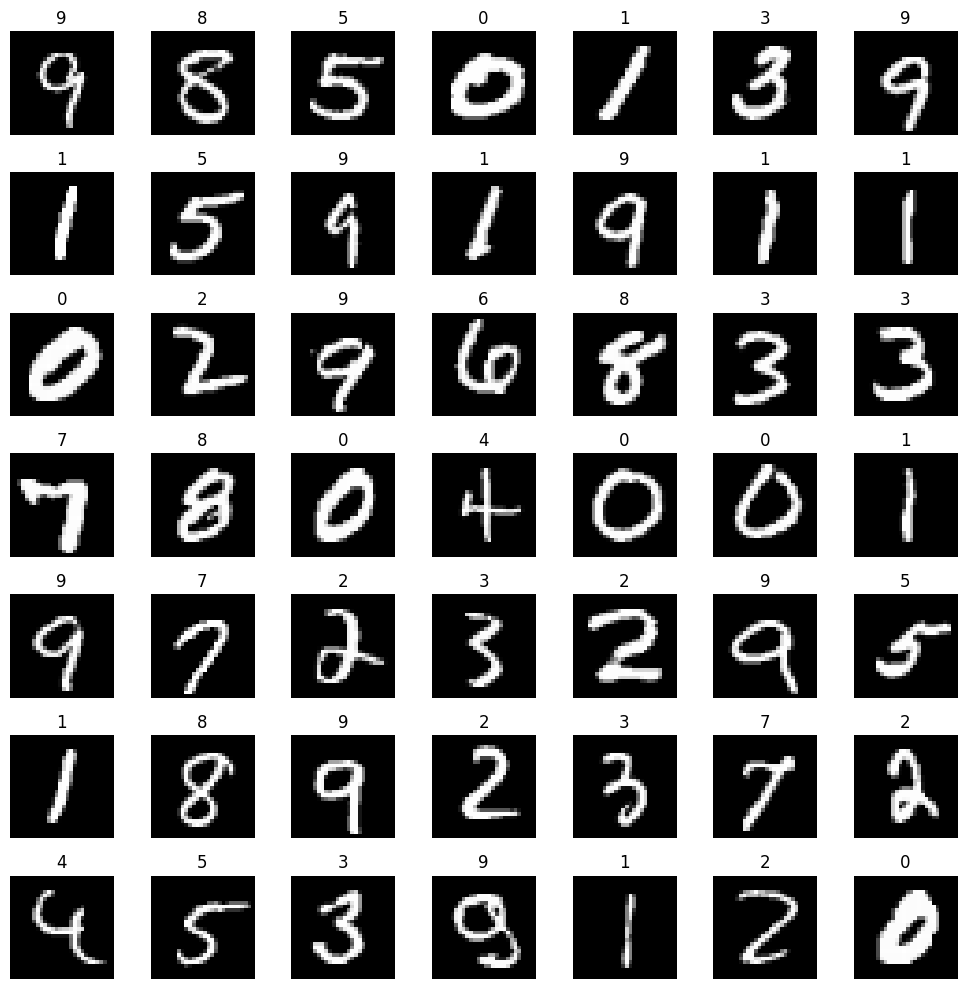

In [11]:
plot_random_mnist_images(test_loader, num_images=49)

In [12]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
batch_size = 512
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomAffine(
                            degrees=10,  # Random rotation up to 10 degrees
                        ),                        
                        transforms.RandomErasing(p=0.1),
                        transforms.ElasticTransform(alpha=34.0, sigma=4.0),
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [13]:
from src.model import MiniCNN_3

In [14]:
model = MiniCNN_3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             576
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,152
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             128
           Conv2d-12            [-1, 8, 14, 14]             576
      BatchNorm2d-13            [-1, 8, 14, 14]              16
             ReLU-14            [-1, 8,

#### Layerwise Details

| Layer | Input Size | Output Size | Receptive Field | Jump In | Jump Out |
|-------|------------|-------------|-----------------|----------|-----------|
| Conv1 | 28x28x1 | 28x28x8 | 3 | 1 | 1 |
| Conv2 | 28x28x8 | 28x28x8 | 5 | 1 | 1 |
| Conv3 | 28x28x8 | 28x28x16 | 7 | 1 | 1 |
| MaxPool1 | 28x28x16 | 14x14x16 | 8 | 1 | 2 |
| Transition-Conv1 | 14x14x16 | 14x14x8 | 8 | 2 | 2 |
| Conv4 | 14x14x8 | 14x14x8 | 12 | 2 | 2 |
| Conv5 | 14x14x8 | 14x14x16 | 16 | 2 | 2 |
| Conv6 | 14x14x16 | 14x14x16 | 20 | 2 | 2 |
| MaxPool2 | 14x14x16 | 7x7x16 | 21 | 2 | 4 |
| Transition-Conv1 | 7x7x16 | 7x7x3 | 21 | 4 | 4 |
| FC | 7x7x3 | 10 | - | - | - |


In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=1e-6,
)

for epoch in range(1, 16):
    print(f"********* Epoch = {epoch} *********")
    train(model, device, train_loader, optimizer, epoch)
    _, acc = test(model, device, test_loader)
    scheduler.step(acc)

/Users/aditya/miniconda3/envs/era_dl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


********* Epoch = 1 *********


loss=0.2327 batch_id=117: 100%|██████████| 118/118 [06:02<00:00,  3.07s/it]



Epoch 1: Train set: Average loss: 0.8536, Accuracy: 45171/60000 (75.28%)


Test set: Average loss: 0.1262, Accuracy: 9663/10000 (96.63%)

********* Epoch = 2 *********


loss=0.1900 batch_id=117: 100%|██████████| 118/118 [06:13<00:00,  3.16s/it]



Epoch 2: Train set: Average loss: 0.2109, Accuracy: 56074/60000 (93.46%)


Test set: Average loss: 0.0655, Accuracy: 9793/10000 (97.93%)

********* Epoch = 3 *********


loss=0.1827 batch_id=117: 100%|██████████| 118/118 [06:53<00:00,  3.51s/it]



Epoch 3: Train set: Average loss: 0.1561, Accuracy: 56987/60000 (94.98%)


Test set: Average loss: 0.0570, Accuracy: 9813/10000 (98.13%)

********* Epoch = 4 *********


loss=0.1036 batch_id=117: 100%|██████████| 118/118 [28:39<00:00, 14.57s/it] 



Epoch 4: Train set: Average loss: 0.1384, Accuracy: 57288/60000 (95.48%)


Test set: Average loss: 0.0550, Accuracy: 9813/10000 (98.13%)

********* Epoch = 5 *********


loss=0.0929 batch_id=117: 100%|██████████| 118/118 [06:05<00:00,  3.10s/it]



Epoch 5: Train set: Average loss: 0.1240, Accuracy: 57614/60000 (96.02%)


Test set: Average loss: 0.0391, Accuracy: 9873/10000 (98.73%)

********* Epoch = 6 *********


loss=0.0966 batch_id=117: 100%|██████████| 118/118 [06:07<00:00,  3.12s/it]



Epoch 6: Train set: Average loss: 0.1141, Accuracy: 57762/60000 (96.27%)


Test set: Average loss: 0.0372, Accuracy: 9879/10000 (98.79%)

********* Epoch = 7 *********


loss=0.0828 batch_id=117: 100%|██████████| 118/118 [06:09<00:00,  3.13s/it]



Epoch 7: Train set: Average loss: 0.1104, Accuracy: 57847/60000 (96.41%)


Test set: Average loss: 0.0318, Accuracy: 9891/10000 (98.91%)

********* Epoch = 8 *********


loss=0.1041 batch_id=117: 100%|██████████| 118/118 [06:11<00:00,  3.15s/it]



Epoch 8: Train set: Average loss: 0.1061, Accuracy: 57934/60000 (96.56%)


Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)

********* Epoch = 9 *********


loss=0.0894 batch_id=117: 100%|██████████| 118/118 [06:13<00:00,  3.16s/it]



Epoch 9: Train set: Average loss: 0.0995, Accuracy: 58105/60000 (96.84%)


Test set: Average loss: 0.0324, Accuracy: 9895/10000 (98.95%)

********* Epoch = 10 *********


loss=0.3044 batch_id=117: 100%|██████████| 118/118 [06:14<00:00,  3.17s/it]



Epoch 10: Train set: Average loss: 0.0953, Accuracy: 58149/60000 (96.92%)


Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

********* Epoch = 11 *********


loss=0.0773 batch_id=117: 100%|██████████| 118/118 [06:13<00:00,  3.16s/it]



Epoch 11: Train set: Average loss: 0.0946, Accuracy: 58157/60000 (96.93%)


Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

********* Epoch = 12 *********


loss=0.0670 batch_id=117: 100%|██████████| 118/118 [06:13<00:00,  3.17s/it]



Epoch 12: Train set: Average loss: 0.0926, Accuracy: 58146/60000 (96.91%)


Test set: Average loss: 0.0359, Accuracy: 9887/10000 (98.87%)

********* Epoch = 13 *********


loss=0.0729 batch_id=117: 100%|██████████| 118/118 [06:15<00:00,  3.18s/it]



Epoch 13: Train set: Average loss: 0.0910, Accuracy: 58234/60000 (97.06%)


Test set: Average loss: 0.0258, Accuracy: 9916/10000 (99.16%)

********* Epoch = 14 *********


loss=0.1062 batch_id=117: 100%|██████████| 118/118 [06:19<00:00,  3.21s/it]



Epoch 14: Train set: Average loss: 0.0859, Accuracy: 58303/60000 (97.17%)


Test set: Average loss: 0.0356, Accuracy: 9881/10000 (98.81%)

********* Epoch = 15 *********


loss=0.0955 batch_id=117: 100%|██████████| 118/118 [06:14<00:00,  3.18s/it]



Epoch 15: Train set: Average loss: 0.0803, Accuracy: 58394/60000 (97.32%)


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)



In [16]:
scheduler.get_last_lr()

[0.0001]